# Clustering Basketball Players
### Roland Zhou & Mohammad Radiyat


## Introduction 
### Goal
In sports, scouting new players is a constant problem that teams must deal with to maintain their competitive advantage. Usually coaches rely on various signals to make scouting decisions, including player physique, performance in college leagues, and their own intuition and prior experience. However, machine learning, specifically clustering, may be able to find solutions to this problem much more efficiently and/or effectively. The intuition behind clustering is that coaches would want their teams to be as well-balanced as possible instead of focusing on one specific kind of player. Ideally clustering would separate players out such that coaches could just pick somewhat evenly from clusters for a well-balanced selection of players. 

The goal of this project, then, is to try to see how effectively we can cluster basketball players into five groups and then make sense of the clustering using various visualizations. Some researchers have tried using Gaussian mixture models [[footballresearch2017](http://www.redalyc.org/pdf/710/71051616004.pdf)] on various sources of player statistics information to cluster players together to determine how to separate different kinds of players most optimally. We will also demonstrate the GMM using Edward, and then modify our model by using a Poisson distribution for some of the player statistics instead of Gaussians. 

### Background
#### Basketball background
Professional basketball is a 5-on-5 team sport where each player on a team normally takes up a different position. Players aim to put the ball into a basket on opposing sides of the court. Shots made close to the basket are worth 2 points, and shots made from far enough away from the basket are worth 3 points (referred to as 3-pointers). 

Some important player stats that we use are:
* Points scored
* Rebounds - # times a player received the ball off of a missed scoring attempt
* Assists - # times a player passed a ball to another player who scored
* Steals - # times a player took the ball from the opposing team during normal play
* Blocks - # times a player successfully blocked a shot from scoring

The 5 positions that players can occupy are:
* Point guard - usually the team's best passer and ball handler. They focus on assists and steals, and are responsible for leading the team on plays
* Shooting guard - players who focus primarily on shooting, especially 3-pointers. 
* Power forward - prolific scorers able to score close to the basket or through shooting from afar. They rely on strength to guard larger players and athleticism to guard quick players. 
* Small forward - versatile players who are able to do a little bit of everything, including shooting, passing, foul shots, and aggressively scoring close to the basket.
* Center - usually the tallest player, focusing on scoring close to the basket and on rebounds and blocks

![](https://i.pinimg.com/originals/6a/85/28/6a85281a70ff8a6b5391681091a87a11.gif)

Fig 1. Basketball positions

#### Statistical background
Gaussian Mixture Models (GMMs) are one of the most widely used types of clustering methods. They assume that data points $x_1, x_2...x_n$ are all independent identically distributed data points, and that they come from a mixture density $p(x) = \sum_{k=1}^K \pi_kp_k(x)$ where $p_k(x)$ is the normal probability density function of the observations in group $k$ and the $\pi$s are the probabilities that an observation comes from the $k^{th}$ mixture component. Each of the normal probability distributions has its own mean $\mu_k$ and deviation $\sigma_k$. The $k$-dimensional $\pi$ mixes the Gaussian components and is defined such that $\sum_1^K\pi_k = 1$. 

These multivariate Gaussian components can be replaced or changed, and in this case we'll change some of the Gaussians to Poissons, each with its own rate parameter $\lambda$. Instead of having every data variable be modeled with a Gaussian, we'll have some modeled with a Gaussian and others modeled with a Poission. 

### Data

# Prereqs

In [0]:
!pip install tensorflow==1.6

    100% |████████████████████████████████| 45.9MB 741kB/s 
    100% |████████████████████████████████| 3.1MB 10.9MB/s 
    100% |████████████████████████████████| 890kB 11.8MB/s 
  Running setup.py bdist_wheel for html5lib ... - \ done
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: bleach 3.0.2
    Uninstalling bleach-3.0.2:
      Successfully uninstalled bleach-3.0.2
  Found existing installation: tensorboard 1.12.0
    Uninstalling tensorboard-1.12.0:
      Successfully uninstalled tensorboard-1.12.0
  Found existing installation: tensorflow 1.12.0
    Uninstalling tensorflow-1.12.0:
      Successfully uninstalled tensorflow-1.12.0


In [0]:
!pip install edward

    100% |████████████████████████████████| 71kB 6.6MB/s 
  Running setup.py bdist_wheel for edward ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ae/61/0c/1f36f3f0c629d1b7a24d042d2c37015a66c091729c95dd8425
Successfully built edward


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.0-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...


In [0]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


# First Run (raw data, no scaling)

## Modeling

We model our raw data without scaling it using a Gaussian mixture model to get a baseline. We take note of the number of training samples $N$ and number of features $D$. 

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf

In [0]:
csv = pd.read_csv('drive/player_season_stats.csv', index_col = 0)
csv = csv[csv.Year>=2011]
csv = csv.fillna(csv.mean())
count_columns = [col for col in csv.columns if not (('%' in col) or (col in ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']))]
count_csv = csv[count_columns]
total_csv = csv.drop_duplicates(subset = ['Year', 'Player'], keep='first')[count_columns]

In [0]:
x_train = np.array(total_csv.drop(['Year', 'Player', 'Pos', 'Tm', 'MP'], axis=1))
N = x_train.shape[0]
D = x_train.shape[1]
K = 5

For a Gaussian mixture model, the likelihood of a data point $x_n$ is 
> $p(x_n|\pi, \mu, \sigma) = \sum_{k=1}^K\pi_k Normal(x_n|\mu_k, \sigma_k)$

The prior on $\pi$ is defined as 
> $p(\pi) = Dirichlet(\pi|\alpha_k)$ 

where $\alpha = 1$. Each component's mean's prior is defined as 
> $p(\mu_k) = Normal(\mu_k|0, I)$

where the covariance is $I$, or the identity matrix. Lastly, each component's variance's prior is defined as 
>$p(\sigma^2_k) = InverseGamma(\sigma^2_k|a,b)$

where $a$ and $b$ are $D$-length vectors of 1s. 

Then we can define the distribution of the mixture conditional on mixture assignments with a latent variable for the assignments using Edward's ParamMixture class, which takes mixing probabilities, component parameters, and component distributions as inputs. 

In [0]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical

#tf.reset_default_graph()

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

## Inference

We use Gibbs sampling to draw from the conditionals of each distribution. We set up empirical random variables to estimate the posterior using the sampling. 

In [0]:
T = 500  # number of MCMC samples

qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

ValueError: ignored

Next we run Gibbs sampling using a training loop. 

In [0]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  #if t % inference.n_print == 0:
  #  print("\nInferred cluster means:")
  #  print(sess.run(running_cluster_means, {t_ph: t - 1}))

/usr/local/lib/python3.6/dist-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 206s | Acceptance Rate: 1.000


# Criticism

We first look at how well-separated the clusters are by using PCA to reduce the dimensionality of the cluster means to 2 and then using a scatterplot. The clusters seem to be fairly well-separated. 

In [0]:
cluster_means = sess.run(running_cluster_means, {t_ph: t - 1})

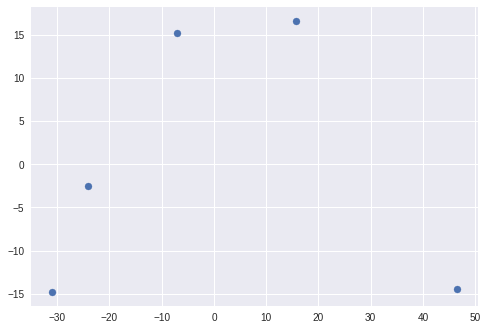

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
stats_transformed = pca_model.fit_transform(cluster_means)
plt.scatter(stats_transformed[:,0], stats_transformed[:, 1])

Next we plot the log likelihoods of each data point, reduced to two dimensions using PCA. We assign each data point to a the cluster that yields highest likelihood for that point, and plot that. 

In [0]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.cast(tf.ones([N, 1, 1, 1]) * mu_sample, tf.float64),
                scale=tf.cast(tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample), tf.float64))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
#print(log_liks.shape)
#log_liks.eval()[:10]

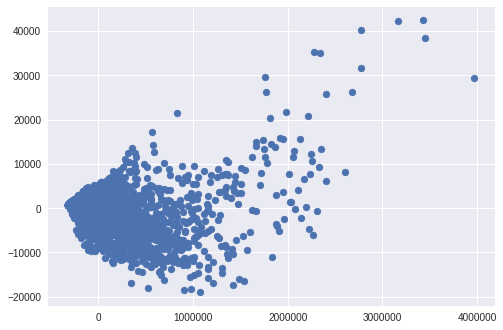

In [0]:
log_ll_values = sess.run(log_liks)

log_ll_values_2d = PCA(n_components=2).fit_transform(log_ll_values)
plt.scatter(log_ll_values_2d[:,0], log_ll_values_2d[:, 1])

In [0]:
max_log_liks = np.max(log_liks.eval(), 1)

plt.hist(max_log_liks, bins=20)
plt.show()

We notice the very strange phenomenon of some of the log likelihoods being greater than 0, which should not happen given that the likelihoods themselves should never surpass 1. We spent a while looking into potential reasons for this, but have found nothing that would suggest that our approach was faulty. 

Next, we count the how many of our training points are in each cluster. 

In [0]:
from collections import Counter

clusters = tf.argmax(log_liks, 1).eval()

counts = Counter(clusters)
counts.most_common(5)

[(1, 848), (2, 656), (0, 640), (4, 622), (3, 567)]

One thing that we are interested in is whether clustering separates players by position well, so we count players per position per cluster.

For each player (except for players that appear only once in our data), we count the proportion of times he is placed into each of the 5 clusters, and plot the max of these proportions per player on a histogram. We do this as a check on how confident the clustering is per player. 

Lastly we visualize position/cluster counts on a heatmap. 

In [0]:
positions = total_csv['Pos'].tolist()
pos_clusters = pd.DataFrame(list(zip(positions, clusters)), columns=['Pos', 'Cluster'])
pos_clusters = pos_clusters[pos_clusters['Pos'].isin(['C', 'PF', 'PG', 'SF', 'SG'])]
print(pos_clusters.groupby(['Pos', 'Cluster']).size())


Pos  Cluster
C    0          139
     1          163
     2          151
     3           81
     4          126
PF   0          126
     1          183
     2          144
     3          101
     4          117
PG   0          104
     1          148
     2          139
     3          121
     4          114
SF   0          125
     1          163
     2          102
     3          112
     4          137
SG   0          137
     1          177
     2          114
     3          144
     4          117
dtype: int64


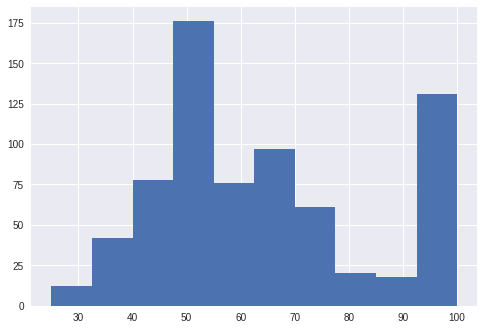

In [0]:
#get dataframe of players and their respective clusters
players = total_csv['Player'].tolist()
player_clusters = pd.DataFrame(list(zip(players, clusters)), columns=['Player', 'Cluster'])

#get rid of players who appear once
player_clusters = player_clusters[player_clusters.groupby('Player').Player.transform(len) > 1]

#get relative frequency of each player's appearance in each cluster
player_clusters = pd.DataFrame(player_clusters.groupby(['Player', 'Cluster']).size())
player_clusters = player_clusters.groupby(['Player', 'Cluster']).agg({0: 'sum'})
player_clusters = player_clusters.groupby(level=0)
player_clusters = pd.DataFrame(player_clusters.apply(lambda x: 100 * x / float(x.sum())))

#only keep the max relative frequency per player; this is a decent gauge of how confidently they can be clustered
player_clusters = pd.DataFrame(player_clusters.groupby('Player').max())

#visualize
player_clusters[0].hist()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


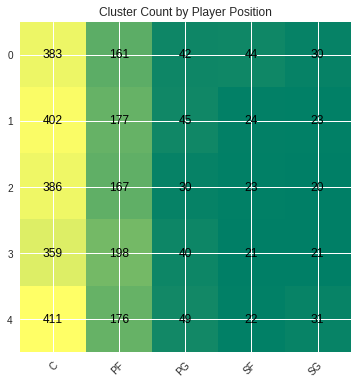

In [0]:
positions = ['C', 'PF', 'PG', 'SF', 'SG']
clusters = list(range(5))

pos_clusters_data = pos_clusters.groupby(['Pos', 'Cluster']).size().reshape([5, 5])


fig, ax = plt.subplots()
im = ax.imshow(pos_clusters_data, cmap = 'summer')

# We want to show all ticks...
ax.set_xticks(np.arange(len(clusters)))
ax.set_yticks(np.arange(len(positions)))
# ... and label them with the respective list entries
ax.set_xticklabels(clusters)
ax.set_yticklabels(positions)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(positions)):
    for j in range(len(clusters)):
        text = ax.text(j, i, pos_clusters_data[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Cluster Count by Player Position")
fig.tight_layout()
plt.show()

The clusters don't seem to separate by position too well; it seems that each cluster has about even numbers of players of each position. 

#Second Run (scaling)

We repeat the above, but by using scikit-learn's StandardScaler to normalize the data. 

## Modeling

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [0]:
csv = pd.read_csv('drive/player_season_stats.csv', index_col = 0)
csv = csv[csv.Year>=2011]
csv = csv.fillna(csv.mean())
count_columns = [col for col in csv.columns if not (('%' in col) or (col in ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']))]
count_csv = csv[count_columns]
total_csv = csv.drop_duplicates(subset = ['Year', 'Player'], keep='first')[count_columns]

In [0]:
x_train = total_csv[total_csv['MP']!=0]

# Standardizing variance across stats
x_train = total_csv.drop(['Year', 'Player', 'Pos', 'Tm', 'MP'], axis=1)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
print(x_train.shape)

N = x_train.shape[0]
D = x_train.shape[1]
K = 5

(3333, 19)


In [0]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical

#tf.reset_default_graph()

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

## Inference

As before, we run Gibbs sampling.

In [0]:
T = 500  # number of MCMC samples

qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

In [0]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  #if t % inference.n_print == 0:
  #  print("\nInferred cluster means:")
  #  print(sess.run(running_cluster_means, {t_ph: t - 1}))

/usr/local/lib/python3.6/dist-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 205s | Acceptance Rate: 1.000


## Criticism

As before, we check how separated the clusters are by first reducing cluster dimensionality to 2. 

In [0]:
cluster_means = sess.run(running_cluster_means, {t_ph: t - 1})

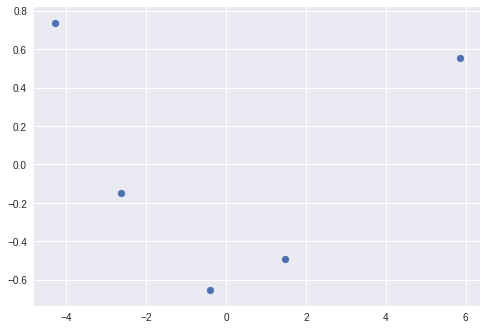

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
stats_transformed = pca_model.fit_transform(cluster_means)
plt.scatter(stats_transformed[:,0], stats_transformed[:, 1])

The clusters are well-separated this time as well. We look again at the log likelihoods per data point.

In [0]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.cast(tf.ones([N, 1, 1, 1]) * mu_sample, tf.float64),
                scale=tf.cast(tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample), tf.float64))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
#print(log_liks.shape)
#log_liks.eval()[:10]

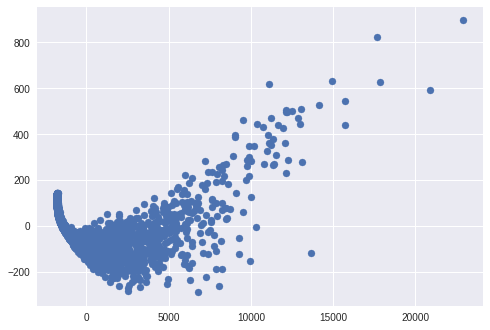

In [0]:
log_ll_values = sess.run(log_liks)

log_ll_values_2d = PCA(n_components=2).fit_transform(log_ll_values)
plt.scatter(log_ll_values_2d[:,0], log_ll_values_2d[:, 1])

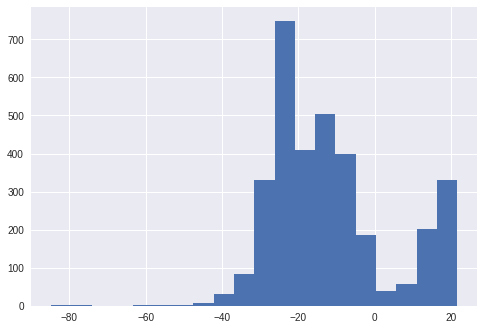

In [0]:
max_log_liks = np.max(log_liks.eval(), 1)

plt.hist(max_log_liks, bins=20)
plt.show()

The log-likelihood scatterplot takes a much more interesting shape than before, but we still have the issue of several points having positive log-likelihoods. 

We count number of points per cluster again to make sure that there is at least some level of spread of data points across clusters. 

In [0]:
from collections import Counter

clusters = tf.argmax(log_liks, 1).eval()

counts = Counter(clusters)
counts.most_common(5)

[(1, 898), (2, 755), (0, 658), (4, 602), (3, 420)]

As before we look at how each cluster separates positions with a heatmap, and look at how well players are clustered with themselves using a histogram. 

In [0]:
positions = total_csv['Pos'].tolist()
pos_clusters = pd.DataFrame(list(zip(positions, clusters)), columns=['Pos', 'Cluster'])
pos_clusters = pos_clusters[pos_clusters['Pos'].isin(['C', 'PF', 'PG', 'SF', 'SG'])]
print(pos_clusters.groupby(['Pos', 'Cluster']).size())


Pos  Cluster
C    0          140
     1          169
     2          164
     3           62
     4          125
PF   0          126
     1          191
     2          165
     3           72
     4          117
PG   0          107
     1          160
     2          166
     3           84
     4          109
SF   0          135
     1          177
     2          120
     3           80
     4          127
SG   0          141
     1          186
     2          133
     3          116
     4          113
dtype: int64


In [0]:
#get dataframe of players and their respective clusters
players = total_csv['Player'].tolist()
player_clusters = pd.DataFrame(list(zip(players, clusters)), columns=['Player', 'Cluster'])

#get rid of players who appear once
player_clusters = player_clusters[player_clusters.groupby('Player').Player.transform(len) > 1]

#get relative frequency of each player's appearance in each cluster
player_clusters = pd.DataFrame(player_clusters.groupby(['Player', 'Cluster']).size())
player_clusters = player_clusters.groupby(['Player', 'Cluster']).agg({0: 'sum'})
player_clusters = player_clusters.groupby(level=0)
player_clusters = pd.DataFrame(player_clusters.apply(lambda x: 100 * x / float(x.sum())))

#only keep the max relative frequency per player; this is a decent gauge of how confidently they can be clustered
player_clusters = pd.DataFrame(player_clusters.groupby('Player').max())

#visualize
player_clusters[0].hist()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


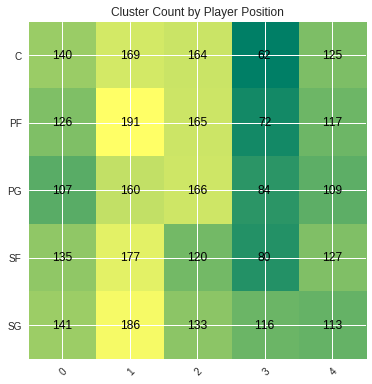

In [0]:
positions = ['C', 'PF', 'PG', 'SF', 'SG']
clusters = list(range(5))

pos_clusters_data = pos_clusters.groupby(['Pos', 'Cluster']).size().reshape([5, 5])


fig, ax = plt.subplots()
im = ax.imshow(pos_clusters_data, cmap = 'summer')

# We want to show all ticks...
ax.set_xticks(np.arange(len(clusters)))
ax.set_yticks(np.arange(len(positions)))
# ... and label them with the respective list entries
ax.set_xticklabels(clusters)
ax.set_yticklabels(positions)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(positions)):
    for j in range(len(clusters)):
        text = ax.text(j, i, pos_clusters_data[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Cluster Count by Player Position")
fig.tight_layout()
plt.show()

With scaled data, cluster 3 does a decent job at picking shooting guards more than other positions, and cluster 1 picks out power forwards and shooting guards better than all other clusters. 

# Third Run (scaling & per-minute stats)

## Modeling

This time, we repeat the analysis but use stats per minute played instead of bulk stats. The data now has signals about player efficiency with respect to time. 

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [0]:
csv = pd.read_csv('drive/player_season_stats.csv', index_col = 0)
csv = csv[csv.Year>=2011]
csv = csv.fillna(csv.mean())
count_columns = [col for col in csv.columns if not (('%' in col) or (col in ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']))]
count_csv = csv[count_columns]
total_csv = csv.drop_duplicates(subset = ['Year', 'Player'], keep='first')[count_columns]

Here we divide each player's stats by their total minutes played during the season. 

In [0]:
x_train = total_csv[total_csv['MP']!=0]

for i in ['FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']:
  x_train[i] = x_train[i].values / x_train['MP'].values


# Standardizing variance across stats
x_train = total_csv.drop(['Year', 'Player', 'Pos', 'Tm', 'MP'], axis=1)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
print(x_train.shape)

N = x_train.shape[0]
D = x_train.shape[1]
K = 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(3333, 19)


In [0]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical

#tf.reset_default_graph()

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

## Inference

We run Gibbs sampling as before. 

In [0]:
T = 500  # number of MCMC samples

qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

In [0]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  #if t % inference.n_print == 0:
  #  print("\nInferred cluster means:")
  #  print(sess.run(running_cluster_means, {t_ph: t - 1}))

/usr/local/lib/python3.6/dist-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 204s | Acceptance Rate: 1.000


## Criticism

We look at the cluster separation as before.

In [0]:
cluster_means = sess.run(running_cluster_means, {t_ph: t - 1})

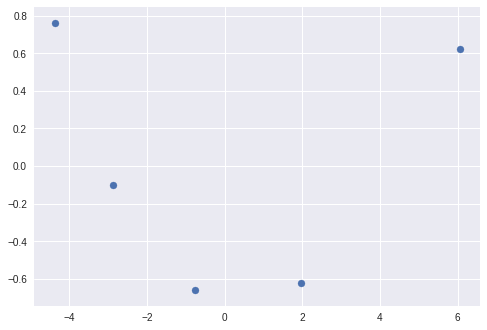

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
stats_transformed = pca_model.fit_transform(cluster_means)
plt.scatter(stats_transformed[:,0], stats_transformed[:, 1])

The clusters are, again, well-separated. We repeat the prior analysis for the log-likelihoods of each of our data points.

In [0]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.cast(tf.ones([N, 1, 1, 1]) * mu_sample, tf.float64),
                scale=tf.cast(tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample), tf.float64))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
#print(log_liks.shape)
#log_liks.eval()[:10]

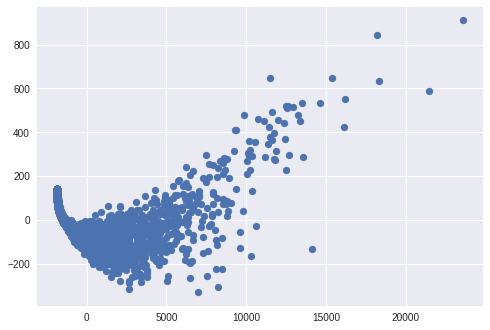

In [0]:
log_ll_values = sess.run(log_liks)

log_ll_values_2d = PCA(n_components=2).fit_transform(log_ll_values)
plt.scatter(log_ll_values_2d[:,0], log_ll_values_2d[:, 1])

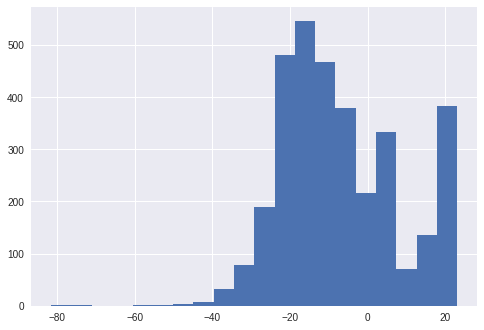

In [0]:
max_log_liks = np.max(log_liks.eval(), 1)

plt.hist(max_log_liks, bins=20)
plt.show()

There are still many points for which the log-likelihood exceeds 0. 

We check membership numbers per cluster again. 

In [0]:
from collections import Counter

clusters = tf.argmax(log_liks, 1).eval()

counts = Counter(clusters)
counts.most_common(5)

[(0, 821), (4, 747), (1, 627), (3, 608), (2, 530)]

Lastly we again look at how each cluster separates positions with a heatmap, and look at how well players are clustered with themselves using a histogram.

In [0]:
positions = total_csv['Pos'].tolist()
pos_clusters = pd.DataFrame(list(zip(positions, clusters)), columns=['Pos', 'Cluster'])
pos_clusters = pos_clusters[pos_clusters['Pos'].isin(['C', 'PF', 'PG', 'SF', 'SG'])]
print(pos_clusters.groupby(['Pos', 'Cluster']).size())

In [0]:
#get dataframe of players and their respective clusters
players = total_csv['Player'].tolist()
player_clusters = pd.DataFrame(list(zip(players, clusters)), columns=['Player', 'Cluster'])

#get rid of players who appear once
player_clusters = player_clusters[player_clusters.groupby('Player').Player.transform(len) > 1]

#get relative frequency of each player's appearance in each cluster
player_clusters = pd.DataFrame(player_clusters.groupby(['Player', 'Cluster']).size())
player_clusters = player_clusters.groupby(['Player', 'Cluster']).agg({0: 'sum'})
player_clusters = player_clusters.groupby(level=0)
player_clusters = pd.DataFrame(player_clusters.apply(lambda x: 100 * x / float(x.sum())))

#only keep the max relative frequency per player; this is a decent gauge of how confidently they can be clustered
player_clusters = pd.DataFrame(player_clusters.groupby('Player').max())

#visualize
player_clusters[0].hist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


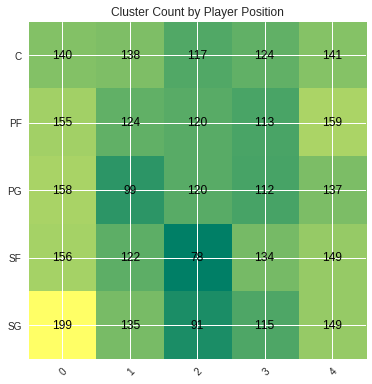

In [0]:
positions = ['C', 'PF', 'PG', 'SF', 'SG']
clusters = list(range(5))

pos_clusters_data = pos_clusters.groupby(['Pos', 'Cluster']).size().reshape([5, 5])


fig, ax = plt.subplots()
im = ax.imshow(pos_clusters_data, cmap = 'summer')

# We want to show all ticks...
ax.set_xticks(np.arange(len(clusters)))
ax.set_yticks(np.arange(len(positions)))
# ... and label them with the respective list entries
ax.set_xticklabels(clusters)
ax.set_yticklabels(positions)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(positions)):
    for j in range(len(clusters)):
        text = ax.text(j, i, pos_clusters_data[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Cluster Count by Player Position")
fig.tight_layout()
plt.show()

This time, it looks like cluster 0 does the best in separating out shooting guards among all positions and among all clusters. Cluster 1 has fewest point guards, and cluster 2 has fewest small forwards and shooting guards. 

 # Poisson

Restart kernel and start from here for the next iteration of Box's loop

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [0]:
csv = pd.read_csv('drive/player_season_stats.csv', index_col = 0)
csv = csv[csv.Year>=2011]
csv = csv.fillna(csv.mean())
count_columns = [col for col in csv.columns if not (('%' in col) or (col in ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']))]
count_csv = csv[count_columns]
total_csv = csv.drop_duplicates(subset = ['Year', 'Player'], keep='first')[count_columns]

In [0]:
x_train = total_csv[total_csv['MP']!=0]
N = x_train.shape[0]
D = x_train.shape[1]
K = 5

Index(['Year', 'Player', 'Pos', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', '3P',
       '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [0]:
#Redefine model here to use Poissons and multivariate normals
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical, Poisson, Independent

#tf.reset_default_graph()

x_pois_data = x_train[['ORB', 'DRB', 'AST', 'STL', 'BLK']]

x_norm_data = x_train[['G', 'GS', 'MP', 'FG', 'FGA', '3P',
       '3PA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PF', 'PTS']]

d_normal = x_norm_data.shape[1]
d_poisson = x_pois_data.shape[1]

pi = Dirichlet(tf.ones(K))
mu_normal = Normal(tf.zeros(d_normal), tf.ones(d_normal), sample_shape=K)
sigmasq_normal = InverseGamma(tf.ones(d_normal), tf.ones(d_normal), sample_shape=K)

rate_poisson = InverseGamma(tf.zeros(d_poisson), tf.ones(d_poisson), sample_shape=K)

x_normal = ParamMixture(pi, {'loc': mu_normal, 'scale_diag': tf.sqrt(sigmasq_normal)},
                        MultivariateNormalDiag,
                        sample_shape=N)
z = x.cat

# Attempt at mixture of MV poissons



qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

# References
1. [[footballresearch2017](http://www.redalyc.org/pdf/710/71051616004.pdf)] Soto-Valero, César. A Gaussian mixture clustering model for characterizing football players using
the EA Sports' FIFA video game system.  Revista Internacional de Ciencias del Deporte, July 2017, Pages 244-259.